<a href="https://colab.research.google.com/github/sangjun315/FedAvg-Pytorch/blob/main/OneshotFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

except ImportError:
     print("Google Colab 환경이 아닙니다. 드라이브 마운트를 건너뜁니다.")

Mounted at /content/drive


In [4]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 2) 라이브러리 임포트 ---")

import os
import pickle
import numpy as np
import scipy.io
import scipy.sparse # Sparse matrix
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm # 진행률 표시

# Sent140 데이터 다운로드용
import urllib.request
import zipfile


print("라이브러리 임포트 완료.")
# Scikit-learn (논문의 SVM, AUC, 전처리용)
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

print("라이브러리 임포트 완료.")


--- (셀 2) 라이브러리 임포트 ---
라이브러리 임포트 완료.
라이브러리 임포트 완료.


In [5]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 3) 경로 및 파라미터 설정 ---")

# --- 기본 경로 ---
BASE_DRIVE_PATH = '/content/drive/My Drive/oneshot/'
DATA_PATH = BASE_DRIVE_PATH
RESULTS_PATH = os.path.join(BASE_DRIVE_PATH, 'results')

# --- Sent140 데이터 경로 ---
SENT140_ZIP_PATH = os.path.join(DATA_PATH, 'trainingandtestdata.zip')
SENT140_CSV_PATH = os.path.join(DATA_PATH, 'training.1600000.processed.noemoticon.csv')


# 결과 저장 폴더 생성
os.makedirs(RESULTS_PATH, exist_ok=True)
print(f"데이터 경로: {DATA_PATH}")
print(f"결과 저장 경로: {RESULTS_PATH}")

# 논문에서 주어진 파라미터
DATASET_PARAMS = {
    'emnist': {'cv': 10, 'data': 100, 'random': 50},
    'sent140': {'cv': 10, 'data': 10, 'random': 50},
    'gleam': {'cv': 10, 'data': 10, 'random': 10},
}
# 논문의 최소 샘플 수 (Section 4)
MIN_SAMPLES_THRESHOLD = {
    'emnist': 60,
    'sent140': 30,
    'gleam': 30
}

# Distillation(증류) 실험용 프록시 샘플 크기 (Figure 3)
PROXY_SAMPLE_SIZES = {
    'emnist': list(range(10, 1501, 50)),
    'sent140': list(range(10, 1501, 50)),
    'gleam': list(range(5, 201, 10))
}

print("경로 및 파라미터 설정 완료.")


--- (셀 3) 경로 및 파라미터 설정 ---
데이터 경로: /content/drive/My Drive/oneshot/
결과 저장 경로: /content/drive/My Drive/oneshot/results
경로 및 파라미터 설정 완료.


In [6]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 4) 데이터 로드 함수 정의 ---")

def load_emnist_data():
    """
    EMNIST .mat 파일 로드 및 전처리.
    반환: { client_id: (X_scaled, y, None) }
    """
    mat_path = os.path.join(DATA_PATH, 'emnist-letters.mat')
    print(f"EMNIST 데이터 로드 중: {mat_path}")
    try:
        mat = scipy.io.loadmat(mat_path)
        data = mat['dataset'][0][0]
        train_images = data['train'][0][0]['images']
        train_labels = data['train'][0][0]['labels'].squeeze()
        train_writers = data['train'][0][0]['writers'].squeeze()
        test_images = data['test'][0][0]['images']
        test_labels = data['test'][0][0]['labels'].squeeze()
        test_writers = data['test'][0][0]['writers'].squeeze()

        all_images = np.concatenate((train_images, test_images))
        all_labels = np.concatenate((train_labels, test_labels))
        all_writers = np.concatenate((train_writers, test_writers))

        all_images_scaled = all_images.reshape(-1, 28 * 28) / 255.0 # 이미 0~1 스케일링됨
        all_labels_binary = np.where(all_labels <= 13, 0, 1)
        print(f"총 이미지: {len(all_images_scaled)}, 총 레이블: {len(all_labels_binary)}, 총 writer: {len(np.unique(all_writers))}")

        client_data = {}
        unique_writers = np.unique(all_writers)
        for writer_id in unique_writers:
            indices = np.where(all_writers == writer_id)[0]
            if not indices.size: continue
            writer_images = all_images_scaled[indices]
            writer_labels = all_labels_binary[indices]
            # 스케일러 불필요 (None)
            client_data[str(writer_id)] = (writer_images, writer_labels, None)

        print(f"EMNIST: {len(client_data)}개의 클라이언트(writer) 데이터 생성 완료.")
        return client_data
    except FileNotFoundError: print(f"파일을 찾을 수 없습니다: {mat_path}"); return None
    except Exception as e: print(f"EMNIST 데이터 로드 오류: {e}"); return None

# (셀 4의 load_sent140_data 함수만 아래 코드로 교체하세요)

def load_sent140_data():
    """
    (수정) Sent140 CSV 로드. Vectorizer 제거.
    이제 원본 텍스트(raw text)를 반환합니다.
    반환: { client_id: (X_text, y, None) }
    """
    print("Sent140 데이터 로드 중 (Pandas 사용)...")
    try:
        if not os.path.exists(SENT140_CSV_PATH):
            print(f"CSV 파일({os.path.basename(SENT140_CSV_PATH)}) 없음.")
            if not os.path.exists(SENT140_ZIP_PATH):
                print(f"오류: {SENT140_ZIP_PATH} 파일을 찾을 수 없습니다.")
                print(f"구글 드라이브 '{DATA_PATH}' 폴더에 'trainingandtestdata.zip' 파일을 직접 업로드해주세요.")
                return None
            print(f"압축 해제 중: {SENT140_ZIP_PATH}")
            with zipfile.ZipFile(SENT140_ZIP_PATH, 'r') as zip_ref:
                zip_ref.extract(os.path.basename(SENT140_CSV_PATH), path=DATA_PATH)
            print("압축 해제 완료.")

        print(f"CSV 로드 중: {SENT140_CSV_PATH}")
        col_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']
        df = pd.read_csv( SENT140_CSV_PATH, encoding='latin-1', header=None, names=col_names )

        # (수정) Vectorizer 관련 로직 모두 제거

        print("Sent140: 클라이언트(user)별 데이터 생성 중 (Raw Text)...")
        client_data = {}
        grouped = df.groupby('user')
        for user_id, group_df in tqdm(grouped, desc="Processing Sent140 clients"):
            X_client_text = group_df['text'].values
            y_client = np.where(group_df['sentiment'].values == 4, 1, 0)
            if not y_client.size: continue

            # (수정) 원본 텍스트와 레이블, 스케일러(None) 반환
            client_data[user_id] = (X_client_text, y_client, None)

        print(f"Sent140: {len(client_data)}개의 클라이언트 데이터 생성 완료 (Raw Text).")
        return client_data
    except Exception as e:
        print(f"Sent140 데이터 로드 오류: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- (GLEAM 로더 함수들) ---
def _get_gleam_eat_intervals(annotate_df):
    intervals = []
    start_time = None
    if not {'Activity', 'Status', 'Time'}.issubset(annotate_df.columns):
        raise ValueError(f"Annotate file missing required columns (Time, Activity, Status). Found: {list(annotate_df.columns)}")
    # 'eat' 및 'eating' 모두 포함하도록 수정
    eat_events = annotate_df[annotate_df['Activity'].str.contains('eat', case=False, na=False)]
    for _, row in eat_events.iterrows():
        status = str(row['Status']).strip().replace('"', '')
        time = row['Time']
        if status == 'start': start_time = time
        elif status == 'stop' and start_time is not None:
            intervals.append((start_time, time)); start_time = None
    return intervals

def _label_gleam_sensor_data(sensor_df, intervals):
    def label_func(timestamp):
        for start, end in intervals:
            if start <= timestamp <= end: return 1
        return 0
    sensor_df['label'] = sensor_df['Unix Time'].apply(label_func)
    return sensor_df

def _create_gleam_features(accel_df):
    WINDOW_SIZE = 50; STEP_SIZE = 25 # 1초 윈도우, 50% 겹침
    features = []; labels = []
    for i in range(0, len(accel_df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = accel_df.iloc[i : i + WINDOW_SIZE]
        # NaN 값 포함될 수 있으므로 mean, std 계산 시 numeric_only 고려
        current_features = []
        for col in ['Value1', 'Value2', 'Value3']:
             # mean, std 외 추가 피처 (min, max, median, var)
            stats = window[col].agg(['mean', 'std', 'min', 'max', 'median', 'var'])
            current_features.extend(stats.tolist())
        features.append(current_features)
        mode_result = window['label'].mode()
        # mode() 결과가 비었거나 window 자체가 비었을 경우 대비
        if not mode_result.empty:
            labels.append(mode_result[0])
        elif not window.empty:
            # mode가 없으면 첫 번째 레이블 사용 (임시 방편)
            labels.append(window['label'].iloc[0])
        # else: # window가 비었으면 아무것도 추가 안 함 (길이 불일치 방지)

    if not features or len(features) != len(labels):
        # print(f"Feature/Label length mismatch: {len(features)} vs {len(labels)}") # 디버깅
        return None, None
    # 생성된 피처의 NaN/Inf 처리 후 반환
    X_client = pd.DataFrame(features).fillna(0).values
    y_client = np.array(labels)
    return X_client, y_client

def load_gleam_data():
    """
    GLEAM 데이터 로드 (타임스탬프 매칭).
    반환: { client_id: (X_unscaled, y, scaler) }
    """
    gleam_path = os.path.join(DATA_PATH, 'GLEAM')
    print(f"GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): {gleam_path}")
    client_folders = [f.path for f in os.scandir(gleam_path) if f.is_dir() and f.name.isdigit()]
    client_data = {}
    print(f"GLEAM: {len(client_folders)}개의 클라이언트 폴더 처리 중...")

    for client_path in tqdm(client_folders, desc="Processing GLEAM clients"):
        client_id = os.path.basename(client_path)
        try:
            annotate_file = glob(os.path.join(client_path, f'{client_id}_annotate.*'))
            if not annotate_file:
                # print(f"Warning: Client {client_id} missing annotate file. Skipping.")
                continue
            # header=None, names=... 로 컬럼명 지정, quote 처리 강화
            annotate_df = pd.read_csv(annotate_file[0], header=None, names=['Time', 'Activity', 'Status'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
            annotate_df[['Activity', 'Status']] = annotate_df[['Activity', 'Status']].astype(str).apply(lambda x: x.str.strip().str.replace('"', ''))
            annotate_df['Time'] = pd.to_numeric(annotate_df['Time'], errors='coerce')
            annotate_df = annotate_df.dropna(subset=['Time', 'Activity', 'Status'])
            if annotate_df.empty:
                # print(f"Warning: Client {client_id} annotate file empty after cleaning. Skipping.")
                continue
            eat_intervals = _get_gleam_eat_intervals(annotate_df)
            if not eat_intervals:
                # print(f"Warning: Client {client_id} has no 'eat' intervals. Skipping.")
                continue

            sensor_file = glob(os.path.join(client_path, f'{client_id}_sensor*'))
            # ._ 파일 제외
            sensor_file = [f for f in sensor_file if 'annotate' not in f.lower() and not os.path.basename(f).startswith('._')]
            if not sensor_file:
                # print(f"Warning: Client {client_id} missing sensor file. Skipping.")
                continue
            # header=None, names=... 로 컬럼명 지정, quote 처리 강화
            sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
            sensor_df['Sensor'] = sensor_df['Sensor'].astype(str).str.strip().str.replace('"', '')
            if not {'Sensor', 'Unix Time'}.issubset(sensor_df.columns):
                # print(f"Warning: Client {client_id} sensor file missing columns. Skipping.")
                continue
            accel_df = sensor_df[sensor_df['Sensor'].str.contains('Accel', case=False, na=False)].copy()
            if accel_df.empty:
                # print(f"Warning: Client {client_id} has no Accelerator data. Skipping.")
                continue
            for col in ['Value1', 'Value2', 'Value3', 'Unix Time']:
                accel_df[col] = pd.to_numeric(accel_df[col], errors='coerce')
            accel_df = accel_df.dropna(subset=['Value1', 'Value2', 'Value3', 'Unix Time']).sort_values(by='Unix Time')
            if accel_df.empty:
                # print(f"Warning: Client {client_id} accel data empty after cleaning. Skipping.")
                continue

            accel_df_labeled = _label_gleam_sensor_data(accel_df.reset_index(drop=True), eat_intervals)
            X_client_unscaled, y_client = _create_gleam_features(accel_df_labeled)

            if X_client_unscaled is None or X_client_unscaled.shape[0] == 0 or len(np.unique(y_client)) < 2:
                # print(f"Warning: Client {client_id} failed feature creation or has only one class. Skipping.")
                continue

            # NaN/Inf 값 처리 후 스케일러 학습 (여기서는 처리만 하고 스케일러 fit은 transform 전에)
            if np.any(np.isnan(X_client_unscaled)) or np.any(np.isinf(X_client_unscaled)):
                 # print(f"Warning: NaN/Inf found in client {client_id} features. Replacing with 0.")
                 X_client_unscaled = np.nan_to_num(X_client_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 # NaN 처리 후에도 데이터가 남아있는지 확인
                 if X_client_unscaled.shape[0] == 0: continue

            # fit_transform 대신 fit만 수행
            scaler = StandardScaler().fit(X_client_unscaled)
            client_data[client_id] = (X_client_unscaled, y_client, scaler)

        except Exception as e:
            # print(f"GLEAM Client {client_id} 처리 오류: {e}") # 디버깅 시 주석 해제
            # traceback.print_exc()
            continue

    print(f"GLEAM: {len(client_data)}개의 클라이언트 데이터 생성 완료.")
    return client_data
# --- (GLEAM 로더 수정 끝) ---

# 데이터 로더 맵
DATA_LOADERS = {
    'emnist': load_emnist_data,
    'sent140': load_sent140_data, # 이 부분이 수정된 함수를 가리키는지 확인
    'gleam': load_gleam_data,
}
print("데이터 로드 함수 정의 완료.")

--- (셀 4) 데이터 로드 함수 정의 ---
데이터 로드 함수 정의 완료.


In [7]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 5) 핵심 실험 함수 정의 ---")

def predict_ensemble(ensemble_models, X_input):
    """앙상블 모델 예측 (입력 X는 스케일링 필요 여부 확인)"""
    if not ensemble_models: return np.full(X_input.shape[0], 0.5)
    all_preds = []

    n_features = -1
    # 첫 번째 모델에서 피처 수 확인 (더 안정적인 방법)
    if ensemble_models:
        first_model = ensemble_models[0]
        if hasattr(first_model, 'n_features_in_') and first_model.n_features_in_ is not None:
            n_features = first_model.n_features_in_
        elif hasattr(first_model, 'support_vectors_') and hasattr(first_model.support_vectors_, 'shape'):
            n_features = first_model.support_vectors_.shape[1]

    if X_input is None or X_input.shape[0] == 0: return np.array([])
    # 차원 불일치 시에도 기본 예측 반환 (오류 방지)
    if n_features != -1 and hasattr(X_input, 'shape') and X_input.ndim == 2 and X_input.shape[1] != n_features:
        # print(f"Warning: Ensemble feature mismatch. Expected {n_features}, got {X_input.shape[1]}")
        return np.full(X_input.shape[0], 0.5)

    for model in ensemble_models:
        try:
             model_n_features = -1
             if hasattr(model, 'n_features_in_') and model.n_features_in_ is not None: model_n_features = model.n_features_in_
             elif hasattr(model, 'support_vectors_') and hasattr(model.support_vectors_, 'shape'): model_n_features = model.support_vectors_.shape[1]

             # n_features가 결정되었고 모델의 피처 수가 다르면 스킵
             if n_features != -1 and model_n_features != n_features:
                 all_preds.append(np.full(X_input.shape[0], 0.5))
                 continue

             # predict_proba 호출 전 입력 데이터 확인
             if X_input is None or X_input.shape[0] == 0: continue

             # Sparse matrix 및 NaN/Inf 처리된 데이터는 바로 사용
             if isinstance(X_input, scipy.sparse.csr_matrix) or not np.isnan(X_input).any():
                pred = model.predict_proba(X_input)[:, 1]
                all_preds.append(pred)
             else: # NaN/Inf 포함 시 0.5 예측
                all_preds.append(np.full(X_input.shape[0], 0.5))

        except Exception as e:
            # print(f"Predict proba error: {e}") # 디버깅
            all_preds.append(np.full(X_input.shape[0], 0.5))

    if not all_preds: return np.full(X_input.shape[0], 0.5)

    # NaN 값 방지 후 평균 계산
    valid_preds = [p for p in all_preds if p is not None and not np.isnan(p).any()]
    if not valid_preds: return np.full(X_input.shape[0], 0.5)
    return np.mean(valid_preds, axis=0)

def evaluate_model(model_or_ensemble, device_eval_info, scaler_type='local', global_scaler_obj=None):
    """ (수정) 모델 평가. scaler_type에 'global_text_vectorizer' 추가. """
    all_device_aucs = []
    is_ensemble = isinstance(model_or_ensemble, list)

    expected_features_ensemble = -1
    if is_ensemble and model_or_ensemble:
        first_model = model_or_ensemble[0]
        if hasattr(first_model, 'n_features_in_') and first_model.n_features_in_ is not None: expected_features_ensemble = first_model.n_features_in_
        elif hasattr(first_model, 'support_vectors_') and hasattr(first_model.support_vectors_, 'shape'): expected_features_ensemble = first_model.support_vectors_.shape[1]

    for client_id, (X_unscaled, y_test, local_scaler) in device_eval_info.items():
        if X_unscaled is None or X_unscaled.shape[0] == 0 or len(np.unique(y_test)) < 2: continue

        try:
            scaler_to_use = None
            if scaler_type == 'global': scaler_to_use = global_scaler_obj
            elif scaler_type == 'local': scaler_to_use = local_scaler
            # (수정) Sent140의 글로벌 Vectorizer를 global_scaler_obj로 받음
            elif scaler_type == 'global_text_vectorizer': scaler_to_use = global_scaler_obj

            X_scaled = X_unscaled
            if scaler_to_use:
                try:
                    # (수정) global_text_vectorizer 처리
                    if scaler_type == 'global_text_vectorizer':
                        # X_unscaled가 raw text이므로 nan_to_num 불필요
                        if X_unscaled.shape[0] > 0: X_scaled = scaler_to_use.transform(X_unscaled)
                        else: continue
                    else: # GLEAM (global/local)
                        if X_unscaled.ndim == 1: X_unscaled = X_unscaled.reshape(1, -1)
                        X_unscaled_clean = np.nan_to_num(X_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                        if X_unscaled_clean.shape[0] > 0: X_scaled = scaler_to_use.transform(X_unscaled_clean)
                        else: continue
                except Exception as scale_e:
                    # print(f"Scaling error client {client_id}: {scale_e}")
                    continue
            elif scaler_type == 'none': # EMNIST (이미 스케일링/벡터화 됨)
                 if isinstance(X_unscaled, scipy.sparse.csr_matrix):
                     X_scaled = X_unscaled
                 else:
                    X_scaled = np.nan_to_num(X_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 if X_scaled.shape[0] == 0: continue

            if X_scaled.shape[0] == 0: continue

            if is_ensemble:
                 if expected_features_ensemble != -1 and X_scaled.shape[1] != expected_features_ensemble: continue
                 y_pred_proba = predict_ensemble(model_or_ensemble, X_scaled)
                 if not hasattr(y_pred_proba, 'shape') or y_pred_proba.shape[0] == 0: continue
            else: # 단일 모델 (Ideal, Local, SVR)
                expected_features = -1
                if hasattr(model_or_ensemble, 'n_features_in_') and model_or_ensemble.n_features_in_ is not None: expected_features = model_or_ensemble.n_features_in_
                elif hasattr(model_or_ensemble, 'support_vectors_') and hasattr(model_or_ensemble.support_vectors_, 'shape'): expected_features = model_or_ensemble.support_vectors_.shape[1]
                is_svr = isinstance(model_or_ensemble, SVR)

                if expected_features != -1 and X_scaled.shape[1] != expected_features: continue

                if is_svr: y_pred_proba = model_or_ensemble.predict(X_scaled)
                else: y_pred_proba = model_or_ensemble.predict_proba(X_scaled)[:, 1]
                if not hasattr(y_pred_proba, 'shape') or y_pred_proba.shape[0] == 0: continue

            if np.isnan(y_pred_proba).any(): all_device_aucs.append(0.5); continue
            y_pred_proba = np.clip(y_pred_proba, 0, 1)

            auc = roc_auc_score(y_test, y_pred_proba)
            all_device_aucs.append(auc)
        except ValueError as ve:
            all_device_aucs.append(0.5)
        except Exception as e:
            # print(f"Error evaluating client {client_id}: {e}")
            all_device_aucs.append(0.5)

    valid_aucs = [auc for auc in all_device_aucs if not np.isnan(auc)]
    return np.mean(valid_aucs) if valid_aucs else 0.5


def run_experiment(dataset_name, client_data):
    """ (수정 5) Sent140 C=5.0 복구, Gleam/Sent140 Local 점수 평가 방식 수정 """
    print(f"--- [{dataset_name}] 실험 시작 ---\n")
    if not client_data: print(f"[{dataset_name}] 데이터가 없어 실험을 건너뜁니다."); return None

    PARAMS = DATASET_PARAMS[dataset_name]
    MIN_SAMPLES = MIN_SAMPLES_THRESHOLD[dataset_name]

    sent140_vectorizer = None
    global_scaler = None # (수정) Gleam의 글로벌 스케일러를 위해 밖으로 이동

    device_models = {}; device_scores = {}
    device_eval_info = {}
    device_local_baseline_scores = {} # (Local Self-Test Score, Fig 2용)
    all_X_train_unscaled, all_y_train = [], []
    all_X_val_unscaled, all_y_val = [], []

    # --- Sent140: Vectorizer 학습 (데이터 누수 방지) ---
    if dataset_name == 'sent140':
        print(f"[{dataset_name}] 1/5: 데이터 분할 및 Global CountVectorizer 학습 중...")
        all_X_train_text = []
        client_data_splits = {}

        for client_id, (X_text, y, _) in tqdm(client_data.items(), desc="Splitting client data"):
            if X_text is None or not hasattr(X_text, 'shape') \
               or X_text.shape[0] < MIN_SAMPLES or len(np.unique(y)) < 2:
                continue
            try:
                X_train_text, X_rem_text, y_train, y_rem = train_test_split(X_text, y, test_size=0.5, random_state=42, stratify=y)
                X_test_text, X_val_text, y_test, y_val = train_test_split(X_rem_text, y_rem, test_size=0.2, random_state=42, stratify=y_rem)
            except ValueError:
                continue

            all_X_train_text.append(X_train_text)
            client_data_splits[client_id] = (X_train_text, y_train, X_test_text, y_test, X_val_text, y_val, None)

        if not all_X_train_text:
            print(f"[{dataset_name}] Vectorizer 학습에 사용할 유효한 데이터가 없습니다.")
            return None

        global_train_corpus = np.concatenate(all_X_train_text)
        sent140_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
        sent140_vectorizer.fit(global_train_corpus)
        print(f"[{dataset_name}] Global CountVectorizer 학습 완료 (Features: {len(sent140_vectorizer.vocabulary_)}).")

        client_data = client_data_splits
        print(f"\n[{dataset_name}] 2/5: 로컬 모델 학습 중...")
    else:
        # EMNIST, GLEAM
        print(f"[{dataset_name}] 1/5: 로컬 모델 학습 중...")

    # --- 메인 클라이언트 루프 ---
    for client_id, data in tqdm(client_data.items(), desc="Training local models"):

        X_train_unscaled, y_train, X_test_unscaled, y_test, X_val_unscaled, y_val = (None,)*6
        local_scaler = None

        if dataset_name == 'sent140':
             X_train_unscaled, y_train, X_test_unscaled, y_test, X_val_unscaled, y_val, local_scaler = data
        else: # EMNIST/GLEAM
            X_unscaled, y, local_scaler = data
            if X_unscaled is None or not hasattr(X_unscaled, 'shape') \
               or (not isinstance(X_unscaled, scipy.sparse.csr_matrix) and X_unscaled.ndim != 2) \
               or X_unscaled.shape[0] < MIN_SAMPLES or len(np.unique(y)) < 2:
                continue
            try:
                X_train_unscaled, X_rem_text, y_train, y_rem = train_test_split(X_unscaled, y, test_size=0.5, random_state=42, stratify=y)
                X_test_unscaled, X_val_unscaled, y_test, y_val = train_test_split(X_rem_text, y_rem, test_size=0.2, random_state=42, stratify=y_rem)
            except ValueError: continue

        # --- 데이터 변환: Vectorize 또는 Scale ---
        X_train, X_test, X_val = X_train_unscaled, X_test_unscaled, X_val_unscaled
        is_already_scaled = (local_scaler is None)

        if dataset_name == 'sent140':
            try:
                X_train = sent140_vectorizer.transform(X_train_unscaled)
                X_test = sent140_vectorizer.transform(X_test_unscaled)
                X_val = sent140_vectorizer.transform(X_val_unscaled)
                is_already_scaled = True
            except Exception as e: continue
        elif not is_already_scaled: # GLEAM
            try:
                X_train_unscaled_clean = np.nan_to_num(X_train_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                X_test_unscaled_clean = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                X_val_unscaled_clean = np.nan_to_num(X_val_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                if X_train_unscaled_clean.shape[0] > 0: X_train = local_scaler.transform(X_train_unscaled_clean)
                else: X_train = np.array([]).reshape(0, X_train_unscaled.shape[1] if X_train_unscaled.ndim > 1 else 0)
                if X_test_unscaled_clean.shape[0] > 0: X_test = local_scaler.transform(X_test_unscaled_clean)
                else: X_test = np.array([]).reshape(0, X_test_unscaled.shape[1] if X_test_unscaled.ndim > 1 else 0)
                if X_val_unscaled_clean.shape[0] > 0: X_val = local_scaler.transform(X_val_unscaled_clean)
                else: X_val = np.array([]).reshape(0, X_val_unscaled.shape[1] if X_val_unscaled.ndim > 1 else 0)
            except Exception as e: continue
        # EMNIST는 is_already_scaled=True (Dense Array)

        if X_train.shape[0] == 0: continue

        # --- (수정) ---
        # Sent140 C=1.0이 과소적합 원인이므로 5.0으로 복구
        local_C = 20.0 if dataset_name == 'sent140' else 1.0
        # --- (수정 끝) ---

        model = SVC(kernel='rbf', probability=True, C=local_C, gamma='scale', class_weight='balanced', random_state=42)
        try:
            if not isinstance(X_train, scipy.sparse.csr_matrix) and (np.isnan(X_train).any() or np.isinf(X_train).any()):
                continue
            model.fit(X_train, y_train)
        except Exception as e: continue

        val_auc = 0.5
        if X_val.shape[0] > 0 and len(np.unique(y_val)) >= 2:
            try:
                pred_proba_val = model.predict_proba(X_val)[:, 1]
                if not np.isnan(pred_proba_val).any(): val_auc = roc_auc_score(y_val, np.clip(pred_proba_val, 0, 1))
            except: pass

        test_auc = 0.5 # 로컬 테스트셋 점수 (Local Baseline, Fig 2용)
        if X_test.shape[0] > 0 and len(np.unique(y_test)) >= 2:
             try:
                 pred_proba_test = model.predict_proba(X_test)[:, 1]
                 if not np.isnan(pred_proba_test).any():
                     test_auc = roc_auc_score(y_test, np.clip(pred_proba_test, 0, 1))
             except: pass

        device_models[client_id] = model
        device_scores[client_id] = val_auc
        device_eval_info[client_id] = (X_test_unscaled, y_test, local_scaler)
        device_local_baseline_scores[client_id] = test_auc # (Self-test 점수, Fig 2용)

        all_X_train_unscaled.append(X_train_unscaled)
        all_y_train.append(y_train)
        all_X_val_unscaled.append(X_val_unscaled)
        all_y_val.append(y_val)

    if not device_models: print(f"[{dataset_name}] 학습 가능한 클라이언트 없음"); return None

    # --- 'Unachievable Ideal' 모델 학습 (EMNIST/Gleam/Sent140 분리) ---
    print(f"\n[{dataset_name}] 3/5: 'Unachievable Ideal' 모델 학습 중...")
    ideal_auc = 0.5
    X_ideal_unscaled_features = None
    ideal_scaler_type = 'none'
    ideal_scaler_obj = None

    if all_X_train_unscaled:
        # 1. Ideal 모델 학습용 피처 준비
        if dataset_name == 'sent140':
            temp_X_list_text = [x for x in all_X_train_unscaled if x is not None and hasattr(x, 'shape') and x.shape[0] > 0]
            if not temp_X_list_text: print(f"[{dataset_name}] Ideal model: 유효한 (Sent140) 텍스트 없음.")
            else:
                X_ideal_unscaled_text = np.concatenate(temp_X_list_text)
                X_ideal_unscaled_features = sent140_vectorizer.transform(X_ideal_unscaled_text) # (Sparse)
                print(f"[{dataset_name}] Ideal model: Sparse (CountVec) 데이터 사용.")
                ideal_scaler_type = 'global_text_vectorizer'
                ideal_scaler_obj = sent140_vectorizer

        else: # EMNIST 또는 GLEAM
            temp_X_list = [x for x in all_X_train_unscaled if x is not None and not isinstance(x, scipy.sparse.csr_matrix) and hasattr(x, 'shape') and x.shape[0] > 0]
            if not temp_X_list: print(f"[{dataset_name}] Ideal model: 유효한 (EMNIST/GLEAM) 데이터 없음.")
            else:
                try:
                    temp_X = np.vstack(temp_X_list)
                    temp_X = np.nan_to_num(temp_X, nan=0.0, posinf=0.0, neginf=0.0)
                    if temp_X.shape[0] > 0:
                        X_ideal_unscaled_features = temp_X
                        if dataset_name == 'gleam':
                            try:
                                global_scaler = StandardScaler().fit(X_ideal_unscaled_features)
                                print(f"[{dataset_name}] Ideal model: 전역 스케일러 학습 완료.")
                                ideal_scaler_type = 'global'
                                ideal_scaler_obj = global_scaler
                            except Exception as e: global_scaler = None
                    else: print(f"[{dataset_name}] Ideal model: 필터링 후 유효한 (EMNIST/GLEAM) 데이터 없음.")
                except ValueError as ve:
                    print(f"Ideal vstack error: {ve}")
                    X_ideal_unscaled_features = None

        # 2. Ideal 모델 공통 학습 로직
        if X_ideal_unscaled_features is not None and X_ideal_unscaled_features.shape[0] > 0:
            X_ideal_scaled = X_ideal_unscaled_features
            if global_scaler: # GLEAM
                try: X_ideal_scaled = global_scaler.transform(X_ideal_unscaled_features)
                except Exception as e: X_ideal_scaled = X_ideal_unscaled_features; global_scaler = None

            is_sparse_train = isinstance(all_X_train_unscaled[0], scipy.sparse.csr_matrix) # (False)
            if is_sparse_train:
                valid_y_train_list = [y for y, x in zip(all_y_train, all_X_train_unscaled) if x is not None and isinstance(x, scipy.sparse.csr_matrix) and x.shape[0] > 0]
            else:
                valid_y_train_list = [y for y, x in zip(all_y_train, all_X_train_unscaled) if x is not None and hasattr(x, 'shape') and x.shape[0] > 0]

            if valid_y_train_list:
                y_ideal = np.concatenate(valid_y_train_list)
                if X_ideal_scaled.shape[0] == y_ideal.shape[0]:
                    ideal_model = SVC(kernel='rbf', probability=True, C=8, gamma='scale', class_weight='balanced', random_state=42)
                    try:
                        ideal_model.fit(X_ideal_scaled, y_ideal)
                        ideal_auc = evaluate_model(ideal_model, device_eval_info, scaler_type=ideal_scaler_type, global_scaler_obj=ideal_scaler_obj)
                    except Exception as fit_e: print(f"Ideal fit error: {fit_e}"); ideal_auc = 0.5
                else:
                    print(f"Ideal X/y mismatch: X={X_ideal_scaled.shape[0]}, y={y_ideal.shape[0]}")
                    ideal_auc = 0.5
            else: ideal_auc = 0.5
        else: ideal_auc = 0.5

    # --- (수정) 앙상블 및 Local (Global) 평가 ---
    print(f"\n[{dataset_name}] 4/5: 'Local' (Global) 및 앙상블 평가 중...")
    eligible_clients = list(device_models.keys()); eligible_scores = device_scores; eligible_models = device_models

    # 평가 기준(스케일러) 설정
    eval_scaler_type = 'none' # EMNIST
    eval_scaler_obj = None
    if dataset_name == 'gleam':
        eval_scaler_type = 'global' # (수정) Ideal과 동일하게 global 사용
        eval_scaler_obj = global_scaler
    elif dataset_name == 'sent140':
        eval_scaler_type = 'global_text_vectorizer'
        eval_scaler_obj = sent140_vectorizer

    # --- (수정) Local (Global) 점수 계산 (Figure 1용) ---
    all_local_global_aucs = []
    print(f"[{dataset_name}] 'Local' (Global Test) 점수 계산 중...")
    for client_id, local_model in tqdm(eligible_models.items(), desc="Evaluating local models globally"):
        # 각 로컬 모델을 글로벌 평가 기준으로 평가
        global_auc = evaluate_model(local_model, device_eval_info, scaler_type=eval_scaler_type, global_scaler_obj=eval_scaler_obj)
        all_local_global_aucs.append(global_auc)

    valid_local_global_aucs = [s for s in all_local_global_aucs if not np.isnan(s)]
    local_global_auc = np.mean(valid_local_global_aucs) if valid_local_global_aucs else 0.5
    # --- (수정 끝) ---

    print(f"[{dataset_name}] 앙상블 모델 평가 중...")
    full_ensemble_models = list(eligible_models.values())
    full_ensemble_auc = evaluate_model(full_ensemble_models, device_eval_info, scaler_type=eval_scaler_type, global_scaler_obj=eval_scaler_obj)

    sorted_clients_cv = sorted(eligible_scores, key=eligible_scores.get, reverse=True)
    cv_clients = sorted_clients_cv[:PARAMS['cv']]
    cv_ensemble_models = [eligible_models[c] for c in cv_clients] if cv_clients else []
    cv_auc = evaluate_model(cv_ensemble_models, device_eval_info, scaler_type=eval_scaler_type, global_scaler_obj=eval_scaler_obj)

    client_sizes = {}
    if dataset_name == 'sent140':
        client_sizes = {cid: (data[1].shape[0] + data[3].shape[0] + data[5].shape[0]) for cid, data in client_data.items() if cid in eligible_clients}
    else:
        client_sizes = {cid: client_data[cid][1].shape[0] for cid in eligible_clients if cid in client_data and client_data[cid] and hasattr(client_data[cid][1], 'shape')}

    sorted_clients_data = sorted(client_sizes, key=client_sizes.get, reverse=True)
    data_clients = sorted_clients_data[:PARAMS['data']]
    data_ensemble_models = [eligible_models[c] for c in data_clients] if data_clients else []
    data_auc = evaluate_model(data_ensemble_models, device_eval_info, scaler_type=eval_scaler_type, global_scaler_obj=eval_scaler_obj)

    random_aucs = []
    random_ensemble_models = []
    if eligible_clients:
        num_to_select = min(PARAMS['random'], len(eligible_clients))
        if num_to_select > 0:
            for _ in range(5):
                random_clients = np.random.choice(eligible_clients, num_to_select, replace=False)
                current_random_ensemble = [eligible_models[c] for c in random_clients] if random_clients.size > 0 else []
                if current_random_ensemble:
                    random_aucs.append(evaluate_model(current_random_ensemble, device_eval_info, scaler_type=eval_scaler_type, global_scaler_obj=eval_scaler_obj))
                    random_ensemble_models = current_random_ensemble
                else:
                    random_aucs.append(0.5)

    valid_random_aucs = [auc for auc in random_aucs if not np.isnan(auc)]
    random_auc = np.mean(valid_random_aucs) if valid_random_aucs else 0.5

    # (수정) Fig 1의 'Local' 점수를 'local_global_auc'로 변경
    fig1_results = {
        'Unachievable Ideal': ideal_auc,
        'Local': local_global_auc, # <-- 수정됨
        'Full Ensemble': full_ensemble_auc,
        f'CV, k={PARAMS["cv"]}': cv_auc,
        f'Data, k={PARAMS["data"]}': data_auc,
        f'Random, k={PARAMS["random"]}': random_auc
    }

    # --- Figure 2/3 Teacher Ensemble 동적 선택 ---
    # (Ensemble 점수들은 이미 'global' 기준으로 공정하게 평가되었음)
    ensemble_results = {
        f'CV, k={PARAMS["cv"]}': cv_auc,
        f'Data, k={PARAMS["data"]}': data_auc,
        f'Random, k={PARAMS["random"]}': random_auc,
        'Full Ensemble': full_ensemble_auc
    }
    valid_ensemble_results = {k: v for k, v in ensemble_results.items() if not np.isnan(v)}
    best_ensemble_name = max(valid_ensemble_results, key=valid_ensemble_results.get) if valid_ensemble_results else 'Full Ensemble'

    fig2_ensemble = []
    if best_ensemble_name == 'Full Ensemble': fig2_ensemble = full_ensemble_models
    elif best_ensemble_name.startswith('CV'): fig2_ensemble = cv_ensemble_models
    elif best_ensemble_name.startswith('Data'): fig2_ensemble = data_ensemble_models
    elif best_ensemble_name.startswith('Random'): fig2_ensemble = random_ensemble_models if random_ensemble_models else full_ensemble_models
    else: fig2_ensemble = full_ensemble_models
    fig2_ensemble_name = best_ensemble_name

    print(f"[{dataset_name}] Best ensemble for Fig 2/3: {best_ensemble_name} (AUC: {valid_ensemble_results.get(best_ensemble_name, 0.0):.3f})")

    # --- Figure 2 Ensemble 점수 계산 (Global 평가 기준 사용) ---
    ensemble_scores_fig2 = []
    for client_id, (X_test_unscaled, y_test, local_scaler) in device_eval_info.items():
        if len(np.unique(y_test)) < 2: continue
        try:
            X_test = X_test_unscaled
            current_scaler = None

            if eval_scaler_type == 'global': # (수정) GLEAM
                current_scaler = global_scaler
            elif eval_scaler_type == 'global_text_vectorizer': # Sent140
                current_scaler = sent140_vectorizer
            # EMNIST는 current_scaler = None

            if current_scaler and eval_scaler_type == 'global' and X_test is not None and X_test.shape[0] > 0: # GLEAM
                 X_test_clean = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 X_test = current_scaler.transform(X_test_clean)
            elif current_scaler and eval_scaler_type == 'global_text_vectorizer': # Sent140
                 X_test = current_scaler.transform(X_test_unscaled)
            elif isinstance(X_test, scipy.sparse.csr_matrix):
                pass
            elif X_test is not None and X_test.shape[0] > 0 and not isinstance(X_test, scipy.sparse.csr_matrix): # EMNIST (Dense)
                X_test = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)

            if X_test is None or X_test.shape[0] == 0: continue

            pred_proba = predict_ensemble(fig2_ensemble, X_test)
            if not np.isnan(pred_proba).any():
                 ensemble_scores_fig2.append(roc_auc_score(y_test, np.clip(pred_proba, 0, 1)))
            else:
                 ensemble_scores_fig2.append(0.5)
        except Exception as e:
            ensemble_scores_fig2.append(0.5)

    # (수정) Fig 2의 'local_scores'는 'Self-Test' 점수(device_local_baseline_scores)를 사용하는 것이 맞음
    fig2_results = {
        'local_scores': list(device_local_baseline_scores.values()),
        'ensemble_scores': ensemble_scores_fig2,
        'ensemble_name': fig2_ensemble_name
    }

    # --- 증류(Distillation) 모델 학습 (EMNIST/Gleam/Sent140 분리) ---
    print(f"\n[{dataset_name}] 5/5: 증류(Distillation) 모델 학습 중...")
    fig3_results = { 'proxy_sizes': [], 'distilled_aucs': [], 'teacher_auc': 0, 'teacher_name': 'N/A' }
    if all_X_val_unscaled:
        # 1. 프록시 데이터 준비
        X_proxy_unscaled = None

        if dataset_name == 'sent140':
             temp_X_list_text = [x for x in all_X_val_unscaled if x is not None and hasattr(x, 'shape') and x.shape[0] > 0]
             if not temp_X_list_text: print(f"[{dataset_name}] Distill: 유효한 (Sent140) 텍스트 없음.")
             else: X_proxy_unscaled = np.concatenate(temp_X_list_text) # (Text array)
        else: # EMNIST 또는 GLEAM
            is_sparse_proxy = isinstance(all_X_val_unscaled[0], scipy.sparse.csr_matrix) # (False)
            temp_X_list = [x for x in all_X_val_unscaled if x is not None and not is_sparse_proxy and hasattr(x, 'shape') and x.shape[0] > 0]
            if not temp_X_list: print(f"[{dataset_name}] Distill: 유효한 (EMNIST/GLEAM) 데이터 없음.")
            else:
                try:
                    temp_X = np.vstack(temp_X_list)
                    X_proxy_unscaled = np.nan_to_num(temp_X, nan=0.0, posinf=0.0, neginf=0.0) # (Dense array)
                except ValueError as ve: X_proxy_unscaled = None

        if X_proxy_unscaled is not None and X_proxy_unscaled.shape[0] > 0:
            if dataset_name != 'sent140':
                 is_sparse_proxy_y = isinstance(all_X_val_unscaled[0], scipy.sparse.csr_matrix) # (False)
                 valid_y_proxy_list = [y for y, x in zip(all_y_val, all_X_val_unscaled) if x is not None and not is_sparse_proxy_y and hasattr(x, 'shape') and x.shape[0] > 0]
            else: # Sent140 y_val 필터링
                 valid_y_proxy_list = [y for y, x in zip(all_y_val, all_X_val_unscaled) if x is not None and hasattr(x, 'shape') and x.shape[0] > 0]

            if not valid_y_proxy_list:
                 print(f"[{dataset_name}] Distill: 유효한 y_val 레이블 없음.")
                 y_proxy = np.array([])
            else:
                y_proxy = np.concatenate(valid_y_proxy_list)

            teacher_ensemble = fig2_ensemble
            teacher_name = fig2_ensemble_name
            teacher_auc = valid_ensemble_results.get(best_ensemble_name, 0.0)

            print(f"[{dataset_name}] Teacher 모델({teacher_name})로 프록시 데이터에 soft-label 생성 중...")
            y_soft_labels = np.array([])
            X_proxy_scaled_for_teacher = X_proxy_unscaled

            # Distillation용 스케일러/벡터라이저 설정 (Gleam 'global' 사용)
            scaler_for_distillation = None
            distill_eval_scaler_type = 'none' # (EMNIST용)
            if dataset_name == 'sent140':
                 scaler_for_distillation = sent140_vectorizer
                 distill_eval_scaler_type = 'global_text_vectorizer'
            elif global_scaler: # GLEAM
                 scaler_for_distillation = global_scaler
                 distill_eval_scaler_type = 'global'

            if scaler_for_distillation:
                 try:
                     if dataset_name == 'sent140':
                         X_proxy_scaled_for_teacher = scaler_for_distillation.transform(X_proxy_unscaled)
                     else: # GLEAM
                         X_proxy_scaled_for_teacher = scaler_for_distillation.transform(X_proxy_unscaled)
                 except Exception as e:
                     print(f"Warning: 프록시 데이터 변환 실패: {e}. 원본 데이터 사용.");
                     scaler_for_distillation = None;
                     X_proxy_scaled_for_teacher = X_proxy_unscaled
                     distill_eval_scaler_type = 'none'
            # EMNIST는 scaler_for_distillation = None

            if X_proxy_scaled_for_teacher is not None and X_proxy_scaled_for_teacher.shape[0] > 0:
                 y_soft_labels = predict_ensemble(teacher_ensemble, X_proxy_scaled_for_teacher)

            distilled_aucs = []
            proxy_sample_sizes = PROXY_SAMPLE_SIZES[dataset_name]
            proxy_sample_sizes = [s for s in proxy_sample_sizes if s <= len(y_soft_labels)]
            if len(y_soft_labels) > 0 and (not proxy_sample_sizes or proxy_sample_sizes[-1] < len(y_soft_labels)):
                proxy_sample_sizes.append(len(y_soft_labels))

            for k in tqdm(proxy_sample_sizes, desc="Distilling"):
                if len(y_soft_labels) == 0: continue
                indices = np.random.choice(len(y_soft_labels), k, replace=False)
                X_proxy_sample = X_proxy_scaled_for_teacher[indices]
                y_soft_sample = y_soft_labels[indices]
                if X_proxy_sample.shape[0] == 0: continue
                try:
                    student_model_svr = SVR(kernel='rbf', C=10.0, gamma='scale').fit(X_proxy_sample, y_soft_sample)
                except Exception as svr_e: distilled_aucs.append(0.5); continue

                mean_student_auc = evaluate_model(student_model_svr, device_eval_info, scaler_type=distill_eval_scaler_type, global_scaler_obj=scaler_for_distillation)
                distilled_aucs.append(mean_student_auc)

            fig3_results = { 'proxy_sizes': proxy_sample_sizes, 'distilled_aucs': distilled_aucs, 'teacher_auc': teacher_auc, 'teacher_name': teacher_name }

    print(f"\n--- [{dataset_name}] 실험 완료 ---\n")
    return { 'fig1': fig1_results, 'fig2': fig2_results, 'fig3': fig3_results }

print("핵심 실험 함수 정의 완료.")

--- (셀 5) 핵심 실험 함수 정의 ---
핵심 실험 함수 정의 완료.


In [6]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 6) EMNIST 실험 실행 ---")

try:
    # 1. EMNIST 데이터 로드
    emnist_client_data = DATA_LOADERS['emnist']()

    # 2. EMNIST 실험 실행
    emnist_results = run_experiment('emnist', emnist_client_data)

    # 3. 결과 저장
    if emnist_results:
        save_path = os.path.join(RESULTS_PATH, 'emnist_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(emnist_results, f)
        print(f"\nEMNIST 결과 저장 완료: {save_path}")
    else:
        print("\nEMNIST 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nEMNIST 실험 중 심각한 오류 발생: {e}")

--- (셀 6) EMNIST 실험 실행 ---
EMNIST 데이터 로드 중: /content/drive/My Drive/oneshot/emnist-letters.mat
총 이미지: 145600, 총 레이블: 145600, 총 writer: 3585
EMNIST: 3585개의 클라이언트(writer) 데이터 생성 완료.
--- [emnist] 실험 시작 ---

[emnist] 1/5: 로컬 모델 학습 중...


Training local models: 100%|██████████| 3585/3585 [00:08<00:00, 428.36it/s]



[emnist] 3/5: 'Unachievable Ideal' 모델 학습 중...

[emnist] 4/5: 'Local' (Global) 및 앙상블 평가 중...
[emnist] 'Local' (Global Test) 점수 계산 중...


Evaluating local models globally: 100%|██████████| 1019/1019 [30:10<00:00,  1.78s/it]


[emnist] 앙상블 모델 평가 중...
[emnist] Best ensemble for Fig 2/3: Data, k=100 (AUC: 0.761)

[emnist] 5/5: 증류(Distillation) 모델 학습 중...
[emnist] Teacher 모델(Data, k=100)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 31/31 [00:44<00:00,  1.44s/it]



--- [emnist] 실험 완료 ---


EMNIST 결과 저장 완료: /content/drive/My Drive/oneshot/results/emnist_results.pkl


In [18]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 7) Sent140 실험 실행 ---")

try:
    # 1. Sent140 데이터 로드
    sent140_client_data = DATA_LOADERS['sent140']()

    # 2. Sent140 실험 실행
    sent140_results = run_experiment('sent140', sent140_client_data)

    # 3. 결과 저장
    if sent140_results:
        save_path = os.path.join(RESULTS_PATH, 'sent140_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(sent140_results, f)
        print(f"\nSent140 결과 저장 완료: {save_path}")
    else:
        print("\nSent140 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nSent140 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 7) Sent140 실험 실행 ---
Sent140 데이터 로드 중 (Pandas 사용)...
CSV 로드 중: /content/drive/My Drive/oneshot/training.1600000.processed.noemoticon.csv
Sent140: 클라이언트(user)별 데이터 생성 중 (Raw Text)...


Processing Sent140 clients: 100%|██████████| 659775/659775 [00:37<00:00, 17463.87it/s]


Sent140: 659775개의 클라이언트 데이터 생성 완료 (Raw Text).
--- [sent140] 실험 시작 ---

[sent140] 1/5: 데이터 분할 및 Global CountVectorizer 학습 중...


Splitting client data: 100%|██████████| 659775/659775 [00:04<00:00, 144759.05it/s]


[sent140] Global CountVectorizer 학습 완료 (Features: 5000).

[sent140] 2/5: 로컬 모델 학습 중...


Training local models: 100%|██████████| 2520/2520 [00:16<00:00, 151.66it/s]



[sent140] 3/5: 'Unachievable Ideal' 모델 학습 중...
[sent140] Ideal model: Sparse (CountVec) 데이터 사용.

[sent140] 4/5: 'Local' (Global) 및 앙상블 평가 중...
[sent140] 'Local' (Global Test) 점수 계산 중...


Evaluating local models globally: 100%|██████████| 2520/2520 [2:51:17<00:00,  4.08s/it]


[sent140] 앙상블 모델 평가 중...
[sent140] Best ensemble for Fig 2/3: Data, k=10 (AUC: 0.645)

[sent140] 5/5: 증류(Distillation) 모델 학습 중...
[sent140] Teacher 모델(Data, k=10)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 31/31 [01:50<00:00,  3.57s/it]


--- [sent140] 실험 완료 ---


Sent140 결과 저장 완료: /content/drive/My Drive/oneshot/results/sent140_results.pkl


In [19]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 8) GLEAM 실험 실행 ---")

try:
    # 1. GLEAM 데이터 로드
    gleam_client_data = DATA_LOADERS['gleam']()

    # 2. GLEAM 실험 실행
    gleam_results = run_experiment('gleam', gleam_client_data)

    # 3. 결과 저장
    if gleam_results:
        save_path = os.path.join(RESULTS_PATH, 'gleam_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(gleam_results, f)
        print(f"\nGLEAM 결과 저장 완료: {save_path}")
    else:
        print("\nGLEAM 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nGLEAM 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 8) GLEAM 실험 실행 ---
GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): /content/drive/My Drive/oneshot/GLEAM
GLEAM: 38개의 클라이언트 폴더 처리 중...


Processing GLEAM clients:   5%|▌         | 2/38 [00:05<01:40,  2.78s/it]/tmp/ipython-input-3322613659.py:181: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
Processing GLEAM clients:  26%|██▋       | 10/38 [00:28<01:18,  2.79s/it]/tmp/ipython-input-3322613659.py:181: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
Processing GLEAM clients:  29%|██▉       | 11/38 [00:32<01:30,  3.35s/it]/tmp/ipython-input-3322613659.py:181: DtypeWarning

GLEAM: 38개의 클라이언트 데이터 생성 완료.
--- [gleam] 실험 시작 ---

[gleam] 1/5: 로컬 모델 학습 중...


Training local models: 100%|██████████| 38/38 [00:04<00:00,  8.18it/s]



[gleam] 3/5: 'Unachievable Ideal' 모델 학습 중...
[gleam] Ideal model: 전역 스케일러 학습 완료.

[gleam] 4/5: 'Local' (Global) 및 앙상블 평가 중...
[gleam] 'Local' (Global Test) 점수 계산 중...


Evaluating local models globally: 100%|██████████| 38/38 [00:26<00:00,  1.43it/s]


[gleam] 앙상블 모델 평가 중...
[gleam] Best ensemble for Fig 2/3: Full Ensemble (AUC: 0.780)

[gleam] 5/5: 증류(Distillation) 모델 학습 중...
[gleam] Teacher 모델(Full Ensemble)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 21/21 [00:01<00:00, 13.76it/s]


--- [gleam] 실험 완료 ---


GLEAM 결과 저장 완료: /content/drive/My Drive/oneshot/results/gleam_results.pkl


In [ ]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 9) Figure 생성 함수 정의 ---")

# Matplotlib 스타일 설정
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('dark_background') # Fallback

def load_result(dataset_name):
    """결과 pkl 파일을 안전하게 로드합니다."""
    load_path = os.path.join(RESULTS_PATH, f'{dataset_name}_results.pkl')
    if not os.path.exists(load_path):
        print(f"경고: {load_path} 에서 결과 파일을 찾을 수 없습니다. (해당 실험 셀을 먼저 실행하세요)")
        return None
    try:
        with open(load_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"결과 파일 로드 오류 ({load_path}): {e}")
        return None

def plot_figure_1(emnist_res, sent140_res, gleam_res):
    """Figure 1: 3개 데이터셋의 평균 AUC 비교 막대 그래프"""

    datasets = {
        'EMNIST': emnist_res['fig1'] if emnist_res else None,
        'Sentiment140': sent140_res['fig1'] if sent140_res else None,
        'Gleam': gleam_res['fig1'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 1: Mean AUC across devices', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        labels = list(data.keys())
        values = list(data.values())

        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))
        bars = ax.bar(labels, values, color=colors)
        ax.set_title(name)
        ax.set_ylabel('Mean AUC Score')
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.5, 1.0)
        elif name == 'Sentiment140':
            ax.set_ylim(0.2, 0.8)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 1.0)

        # 막대 위에 값 표시
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# --- (수정) ---
def plot_figure_2(emnist_res, sent140_res, gleam_res):
    """Figure 2: (수정) 3개 데이터셋의 디바이스 점수 분포 (백분위수)"""

    datasets = {
        'EMNIST': emnist_res['fig2'] if emnist_res else None,
        'Sentiment140': sent140_res['fig2'] if sent140_res else None,
        'Gleam': gleam_res['fig2'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 2: Device score distribution (Percentile by score)', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        local_scores = sorted(data['local_scores'])
        ensemble_scores = sorted(data['ensemble_scores'])
        ensemble_name = data.get('ensemble_name', 'Ensemble') # .get()으로 하위 호환성

        if not local_scores or not ensemble_scores:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Result lists are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # 백분위수 (x축)
        percentiles_local = np.linspace(0, 100, len(local_scores))
        percentiles_ensemble = np.linspace(0, 100, len(ensemble_scores))

        ax.plot(percentiles_local, local_scores, label='Local Scores', lw=2)
        ax.plot(percentiles_ensemble, ensemble_scores, label=f'{ensemble_name} Ensemble', lw=2)

        ax.set_title(name)
        ax.set_xlabel('Percentile (by score)')
        ax.set_ylabel('AUC Score')



        ax.set_ylim(0.0, 1.05) # 기본 범위

        ax.set_xlim(0, 100)
        ax.legend()

    plt.tight_layout()
    plt.show()
# --- (수정 끝) ---

def plot_figure_3(emnist_res, sent140_res, gleam_res):
    """Figure 3: 증류(Distillation) 모델 성능 비교"""

    datasets = {
        'EMNIST': emnist_res['fig3'] if emnist_res else None,
        'Sentiment140': sent140_res['fig3'] if sent140_res else None,
        'Gleam': gleam_res['fig3'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 3: Comparison of distilled model and ensemble', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        proxy_sizes = data['proxy_sizes']
        distilled_aucs = data['distilled_aucs']
        teacher_auc = data['teacher_auc']
        teacher_name = data['teacher_name']

        if not proxy_sizes or not distilled_aucs:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Distillation results are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # Teacher 앙상블 (수평선)
        ax.axhline(y=teacher_auc, color='C0', linestyle='-', lw=3, label=f'{teacher_name} Ensemble (AUC: {teacher_auc:.3f})')

        # Distilled 모델 (라인 그래프)
        # (논문처럼 오차 막대(error bar)를 표시하려면 5회 반복 평균 필요. 여기서는 단일 실행)
        ax.plot(proxy_sizes, distilled_aucs, marker='o', linestyle='--', color='C1', label='Distilled Model')

        ax.set_title(name)
        ax.set_xlabel('Number of Proxy Samples')
        ax.set_ylabel('Mean AUC Score')
        ax.legend()

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.60, 0.8)
        elif name == 'Sentiment140':
            ax.set_ylim(0.5, 0.64)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 0.80 )

    plt.tight_layout()
    plt.show()

print("Figure 생성 함수 정의 완료.")


/tmp/ipython-input-573593007.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-573593007.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-573593007.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


--- (셀 10) 모든 Figure 생성 ---
저장된 결과(.pkl) 로드 중...

--- Figure 1 (Mean AUC) ---


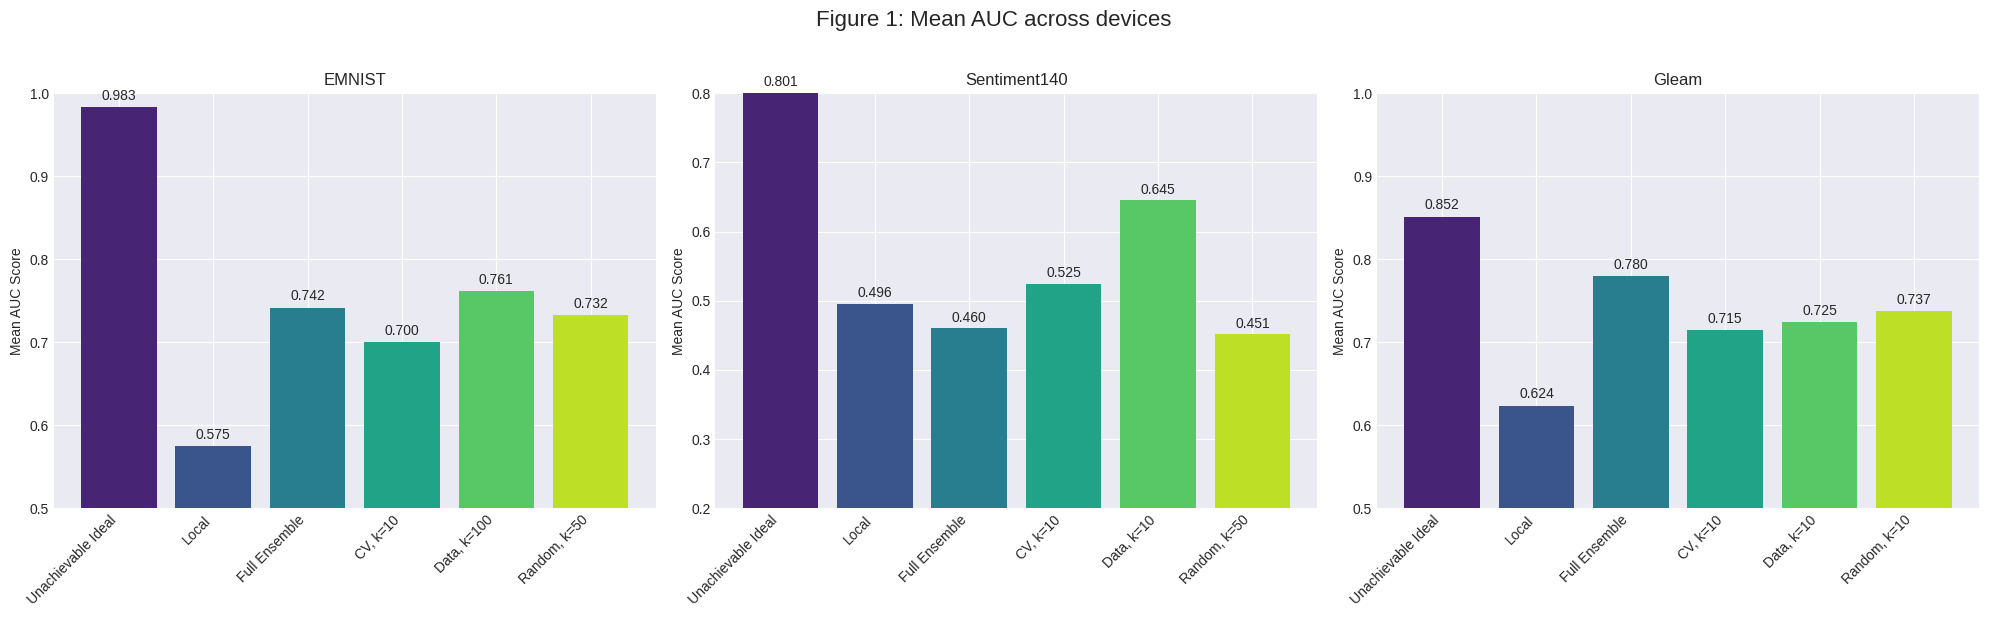


--- Figure 2 (Device Distribution) ---


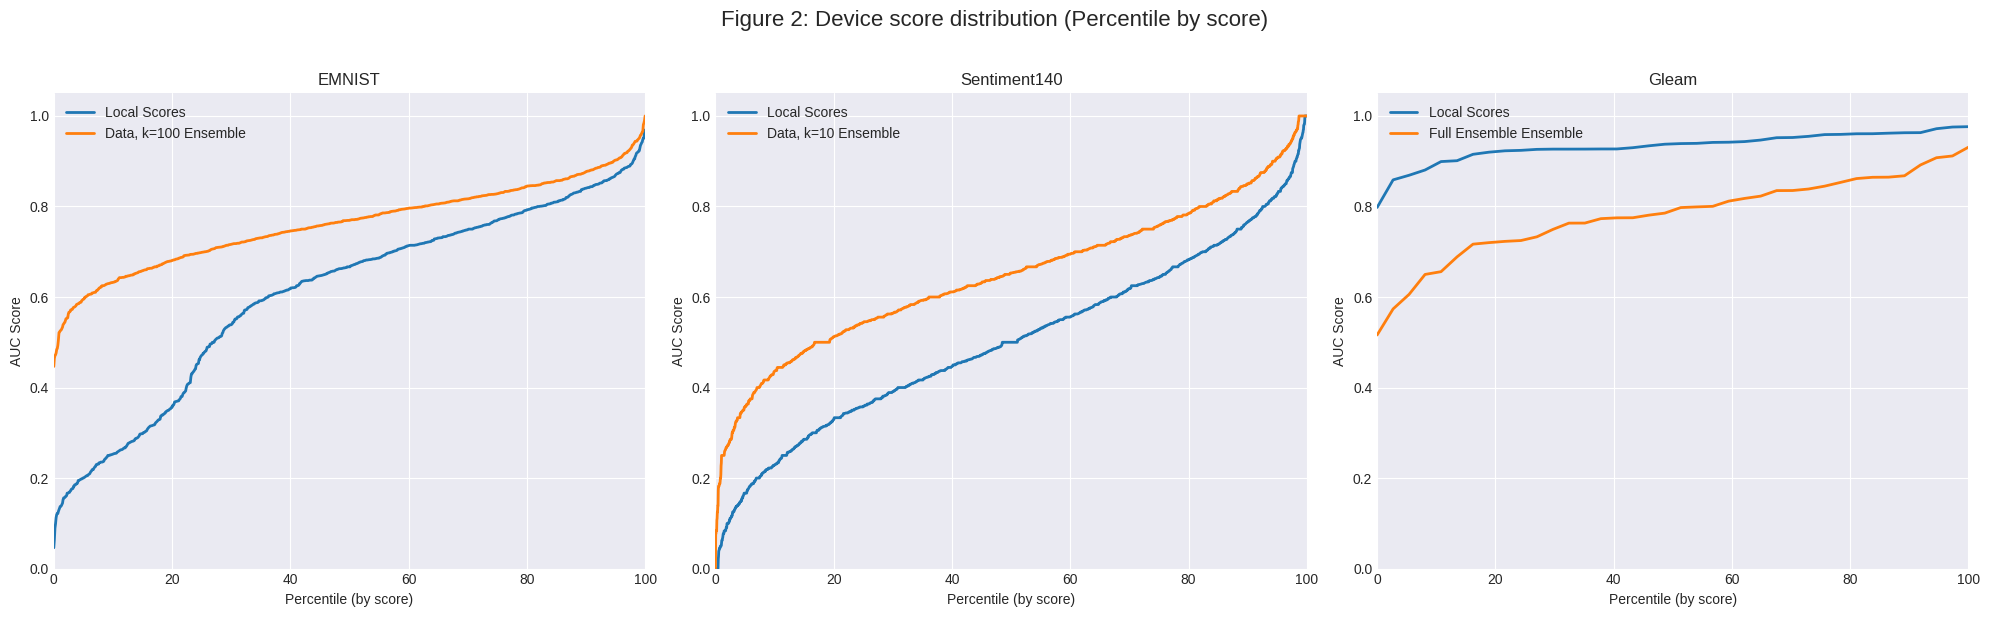


--- Figure 3 (Distillation) ---


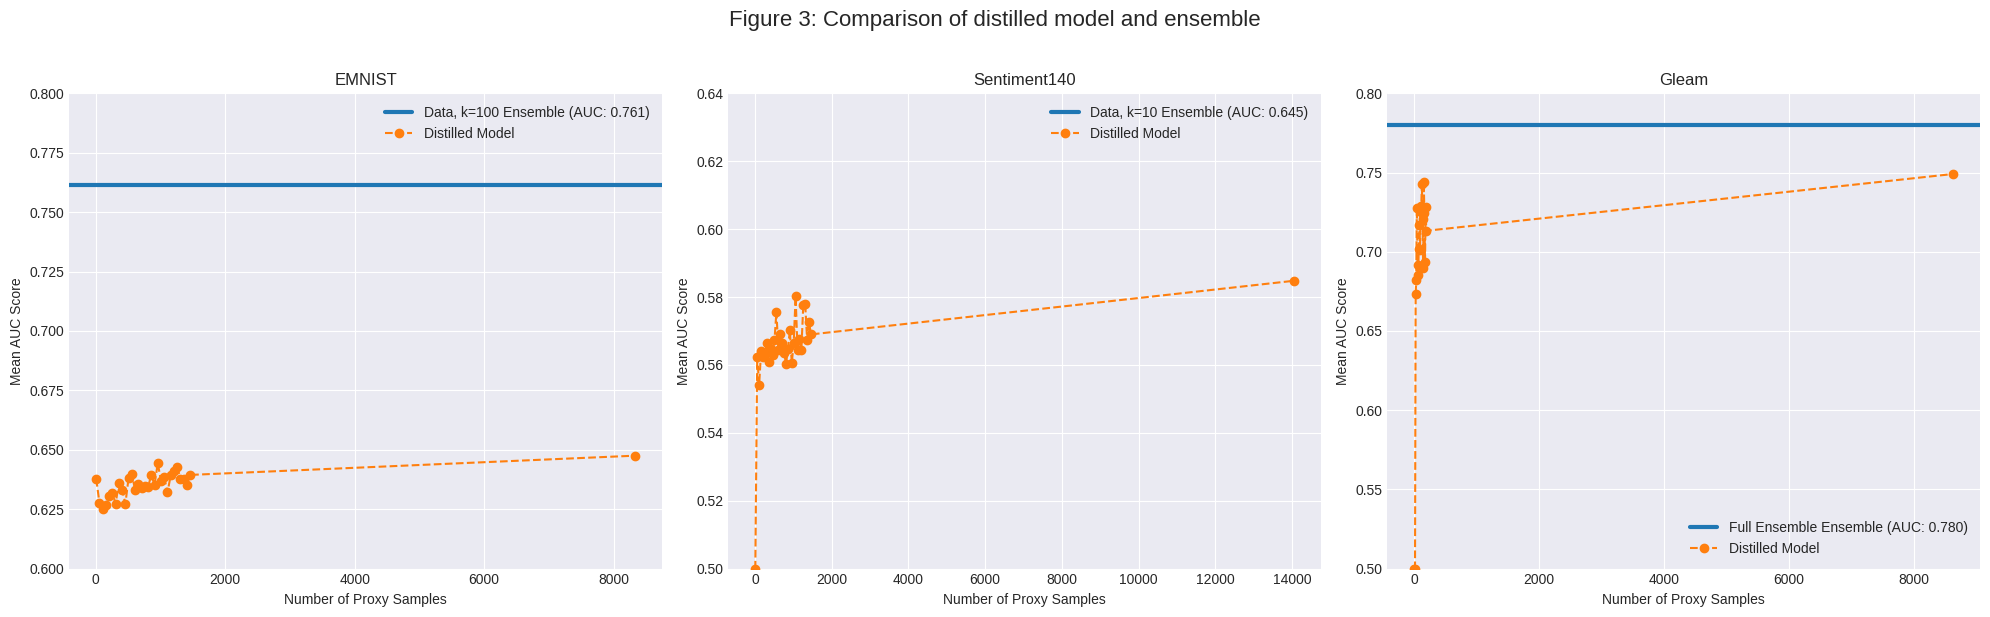


--- Figure 생성 완료 ---


In [21]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 10) 모든 Figure 생성 ---")

# 1. 모든 결과 파일 로드
print("저장된 결과(.pkl) 로드 중...")
emnist_results_loaded = load_result('emnist')
sent140_results_loaded = load_result('sent140')
gleam_results_loaded = load_result('gleam')

# 2. Figure 1 출력
print("\n--- Figure 1 (Mean AUC) ---")
plot_figure_1(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

# 3. Figure 2 출력
print("\n--- Figure 2 (Device Distribution) ---") # (수정)
plot_figure_2(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded) # (수정)

# 4. Figure 3 출력
print("\n--- Figure 3 (Distillation) ---")
plot_figure_3(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

print("\n--- Figure 생성 완료 ---")


In [11]:
import pickle
import os
import numpy as np # numpy 추가

# .pkl 파일 경로 설정 (본인 경로에 맞게 필요시 수정)
results_dir = '/content/drive/My Drive/oneshot/results/'
file_path = os.path.join(results_dir, 'sent140_results.pkl')

print(f"파일 로드 시도: {file_path}")

try:
    # 파일 열기 및 데이터 로드
    with open(file_path, 'rb') as f:
        loaded_results = pickle.load(f)

    # 'fig2' 키와 그 안에 'local_scores' 키가 있는지 확인
    if 'fig2' in loaded_results and 'local_scores' in loaded_results['fig2']:
        local_scores = loaded_results['fig2']['local_scores']

        print(f"\n--- Sent140 로컬 모델별 AUC 점수 (총 {len(local_scores)}개 모델) ---")

        # 모든 로컬 점수 출력 (리스트가 너무 길면 일부만 출력하도록 조절 가능)
        # 예: 처음 100개와 마지막 100개만 출력
        # print("처음 100개:", local_scores[:100])
        # print("마지막 100개:", local_scores[-100:])

        # 전체 리스트 출력 (매우 길 수 있음)
        # print(local_scores)

        # 점수 분포 요약 정보 출력
        print(f"\n점수 요약:")
        print(f"  평균 AUC: {np.mean(local_scores):.4f}")
        print(f"  중앙값 AUC: {np.median(local_scores):.4f}")
        print(f"  최소 AUC: {np.min(local_scores):.4f}")
        print(f"  최대 AUC: {np.max(local_scores):.4f}")
        print(f"  표준 편차: {np.std(local_scores):.4f}")

        # 0.5 미만 점수 개수 확인
        scores_below_0_5 = [score for score in local_scores if score < 0.5]
        print(f"\nAUC < 0.5 인 모델 수: {len(scores_below_0_5)} 개")
        if scores_below_0_5:
            print(f"  (이 모델들이 Full Ensemble 평균을 낮출 수 있습니다)")
            # print("  AUC < 0.5 점수 샘플:", scores_below_0_5[:20]) # 낮은 점수 일부 확인

    else:
        print("오류: 로드된 데이터에 'fig2' 또는 'local_scores' 키가 없습니다.")
        print("파일 내용을 확인해주세요. Sent140 실험이 정상적으로 완료되었는지 확인이 필요할 수 있습니다.")

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {file_path}")
except Exception as e:
    print(f"파일 로드 또는 처리 중 오류 발생: {e}")

파일 로드 시도: /content/drive/My Drive/oneshot/results/sent140_results.pkl

--- Sent140 로컬 모델별 AUC 점수 (총 2520개 모델) ---

점수 요약:
  평균 AUC: 0.4999
  중앙값 AUC: 0.5000
  최소 AUC: 0.0000
  최대 AUC: 1.0000
  표준 편차: 0.2010

AUC < 0.5 인 모델 수: 1236 개
  (이 모델들이 Full Ensemble 평균을 낮출 수 있습니다)
